# Medical Insurance Cost Prediction

In [1]:
%pip install kagglehub
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, normalize
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

In [4]:
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\andre\.cache\kagglehub\datasets\mirichoi0218\insurance\versions\1


In [5]:
df = pd.read_csv(path + '/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


### Exploratory Data Analysis

<Axes: xlabel='region', ylabel='charges'>

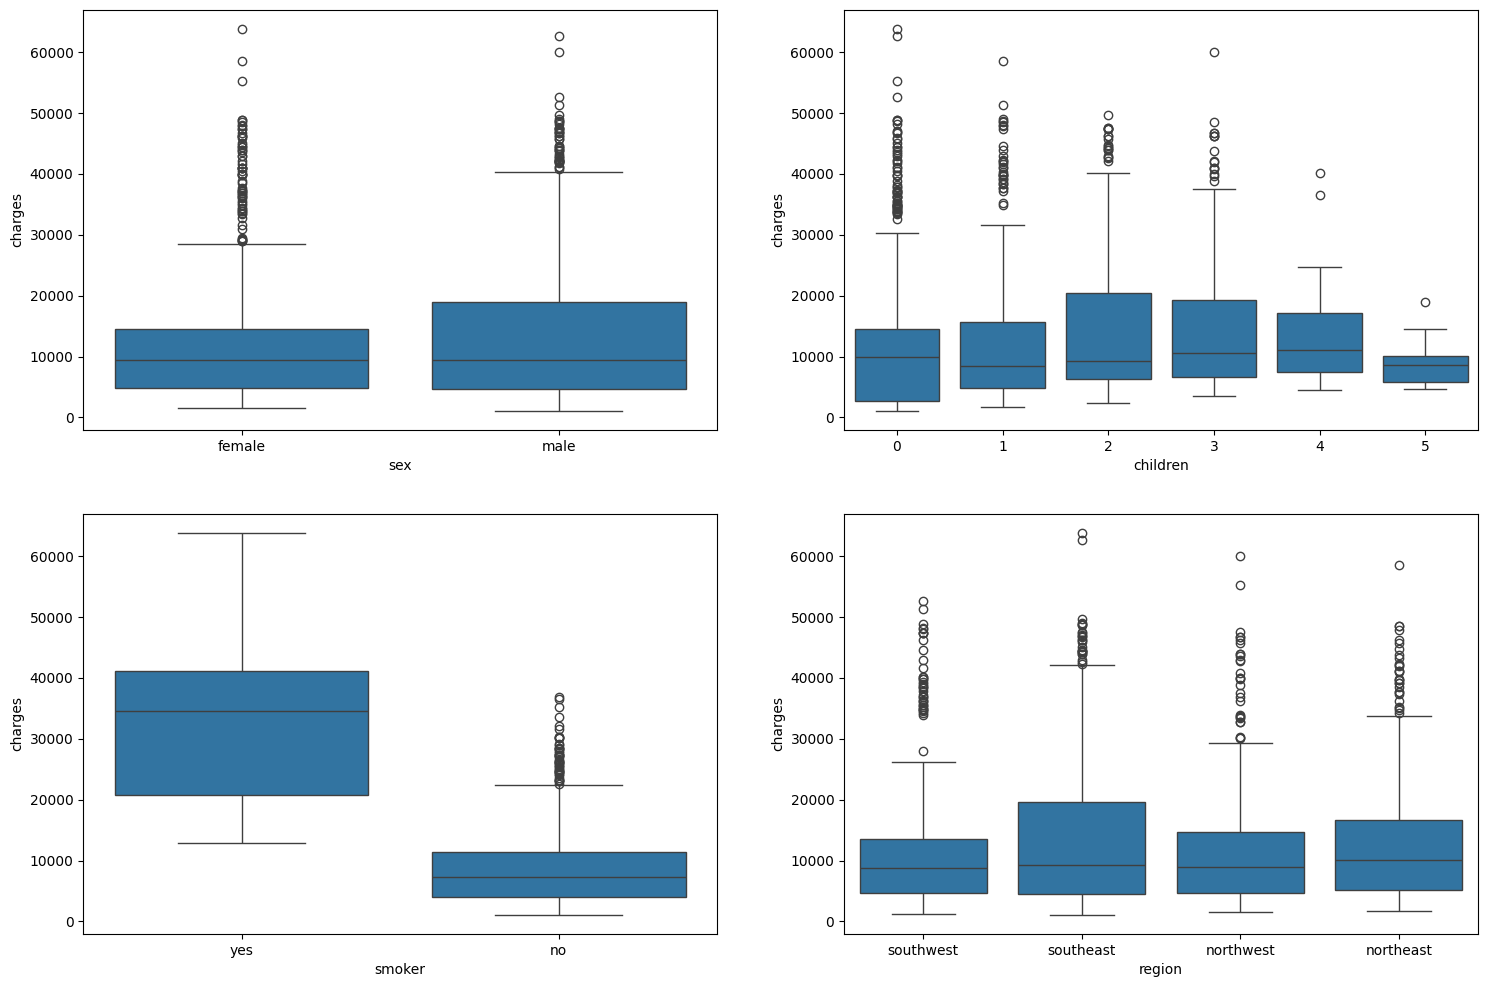

In [8]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.boxplot(x='sex', y='charges', data=df)
plt.subplot(2,2,2)
sns.boxplot(x='children', y='charges', data=df)
plt.subplot(2,2,3)
sns.boxplot(x='smoker', y='charges', data=df)
plt.subplot(2,2,4)
sns.boxplot(x='region', y='charges', data=df)

<Axes: xlabel='bmi', ylabel='charges'>

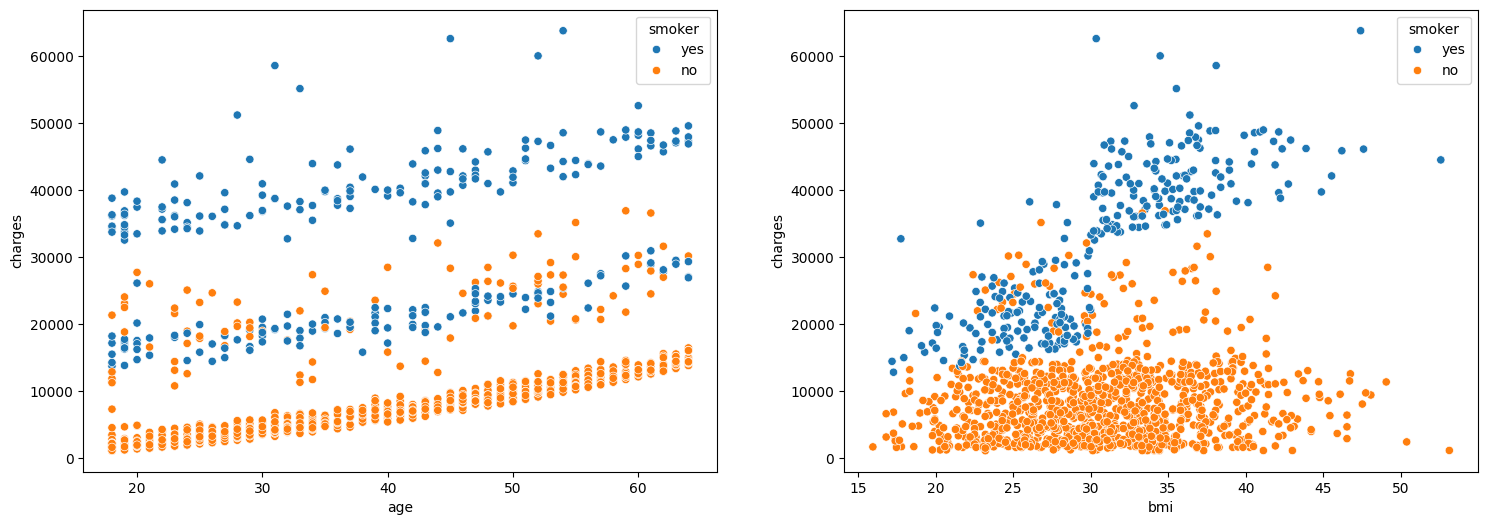

In [9]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')
plt.subplot(1,2,2)
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

In [10]:
df['sex_encoded'] = df['sex'].map({'female': 1, 'male': 0})
df['smoker_encoded'] = df['smoker'].map({'yes': 1, 'no': 0})

df = df.drop(['sex','smoker'], axis=1)

In [11]:
df_encoded = pd.get_dummies(df, columns=['region'], drop_first=True)
df_encoded.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,1,False,False,True
1,18,33.770,1,1725.55230,0,0,False,True,False
2,28,33.000,3,4449.46200,0,0,False,True,False
3,33,22.705,0,21984.47061,0,0,True,False,False
4,32,28.880,0,3866.85520,0,0,True,False,False


Text(0.5, 1.0, 'Correlation Matrix')

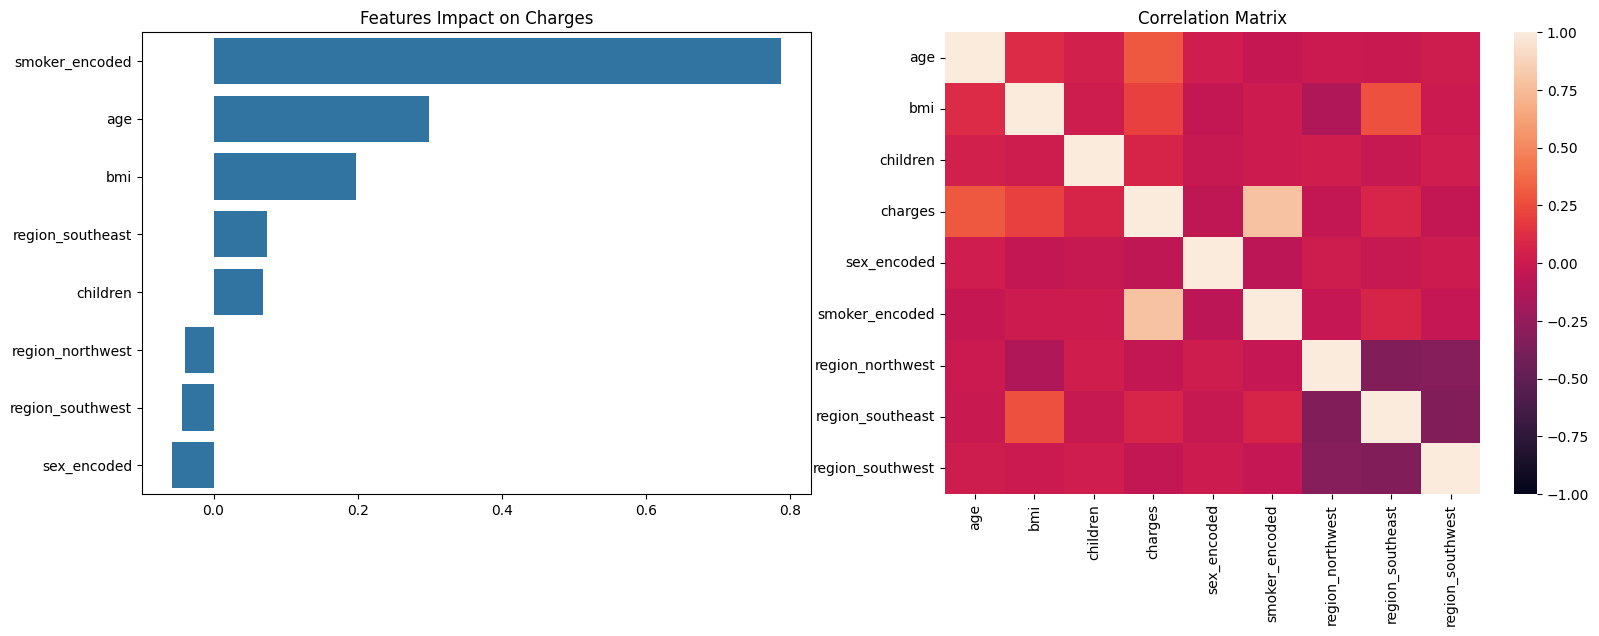

In [12]:
corr = df_encoded.corr()['charges'].drop('charges', axis=0).reset_index().sort_values(by='charges', ascending=False)
corr_matrix = df_encoded.corr()

plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
sns.barplot(data=corr, x='charges', y='index')
plt.title('Features Impact on Charges')
plt.xlabel('')
plt.ylabel('')
plt.subplot(1,2,2)
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.title('Correlation Matrix')

In [13]:
X = df_encoded[['smoker_encoded']]
y = df_encoded.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Simple Linear Model

In [11]:
slm = LinearRegression()

slm.fit(X_train, y_train)

y_train_pred = slm.predict(X_train)
y_test_pred = slm.predict(X_test)

print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

R^2 score on train test: 0.61
R^2 score on test test: 0.66


Text(0.5, 1.0, 'Test')

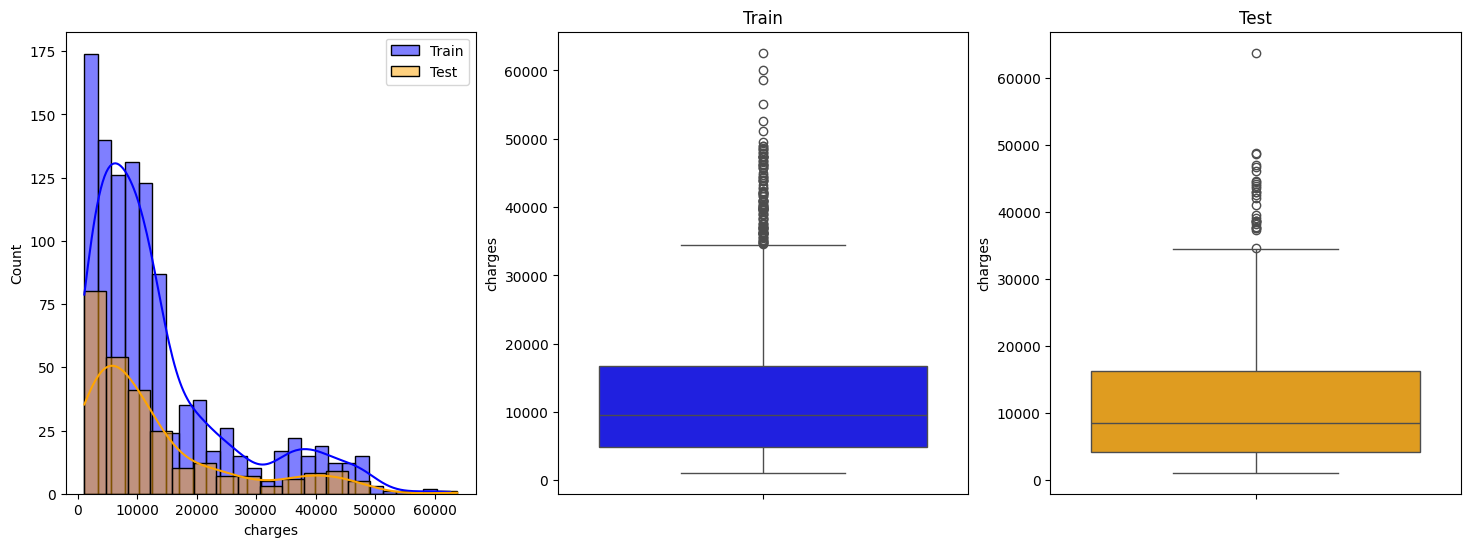

In [18]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.histplot(y_train, color='blue', kde=True, label='Train')
sns.histplot(y_test, color='orange', kde=True, label='Test')
plt.legend()
plt.subplot(1,3,2)
sns.boxplot(y_train, color='blue')
plt.title('Train')
plt.subplot(1,3,3)
sns.boxplot(y_test, color='orange')
plt.title('Test')

The precence of fewer outliers in the test set can explain why the model performs a little better on unseen data.

### Multiple Linear Regression

In [19]:
X = df_encoded.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
mlm = LinearRegression()

mlm.fit(X_train, y_train)
y_train_pred = mlm.predict(X_train)
y_test_pred = mlm.predict(X_test)

print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

R^2 score on train test: 0.74
R^2 score on test test: 0.78


In [21]:
coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': mlm.coef_})
coef.sort_values(by='Coefficient', ascending=False, ignore_index=True)

,Feature,Coefficient
0,smoker_encoded,23651.128856
1,children,425.278784
2,bmi,337.092552
3,age,256.975706
4,sex_encoded,18.591692
5,region_northwest,-370.677326
6,region_southeast,-657.864297
7,region_southwest,-809.799354


In [22]:
print('Intercept:', mlm.intercept_)

Intercept: -11949.810741967724


The negative intercept is due to unscaled data.

###  Polynomial Regression

In [23]:
poly = PolynomialFeatures(degree=2)

X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pm = LinearRegression()

pm.fit(X_train, y_train)

y_train_pred = pm.predict(X_train)
y_test_pred = pm.predict(X_test)

print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

R^2 score on train test: 0.84
R^2 score on test test: 0.87


### Ridge and Lasso Regression Hyperparameters Tuning

In [24]:
X = df_encoded.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

param_grid = [
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 100.0],
        'regressor__solver': ['auto', 'svd', 'cholesky']
    },
    {
        'regressor': [Lasso()],
        'regressor__alpha': [1.0, 10.0, 100.0],
        'regressor__max_iter': [1000, 5000]
    }
]

cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
cv.fit(X_train, y_train)

y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

print('Best parameters:', cv.best_params_)
print('Best score: %.2f' % cv.best_score_)
print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

Best parameters: {'regressor': Lasso(), 'regressor__alpha': 100.0, 'regressor__max_iter': 1000}
Best score: 0.73
R^2 score on train test: 0.74
R^2 score on test test: 0.78


In [25]:
features = X.columns
coefficients = cv.best_estimator_.named_steps['regressor'].coef_

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

selected = coef_df[coef_df['Coefficient'] != 0]
print("Selected features (non-zero coefficients):")
selected.sort_values(by='Coefficient', key=abs, ascending=False, ignore_index=True)

Selected features (non-zero coefficients):


,Feature,Coefficient
0,smoker_encoded,9453.068030
1,age,3528.802468
2,bmi,1892.789994
3,children,424.978753
4,region_southwest,-104.379764
5,region_southeast,-15.589796


In [26]:
print("Intercept:", cv.best_estimator_.named_steps['regressor'].intercept_)

Intercept: 13346.089736364485


### Decision Tree Regression

In [28]:
df_enc = pd.get_dummies(df, columns=['region'])
df_enc.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,1,False,False,False,True
1,18,33.770,1,1725.55230,0,0,False,False,True,False
2,28,33.000,3,4449.46200,0,0,False,False,True,False
3,33,22.705,0,21984.47061,0,0,False,True,False,False
4,32,28.880,0,3866.85520,0,0,False,True,False,False


In [29]:
y = df_enc.charges
X = df_enc.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
dtm = DecisionTreeRegressor()

dtm.fit(X_train, y_train)

y_train_pred = dtm.predict(X_train)
y_test_pred = dtm.predict(X_test)

print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

R^2 score on train test: 1.00
R^2 score on test test: 0.74


No stopping criteria was set, so the tree perfectly memorized the training data (overfitting).

In [31]:
tree = DecisionTreeRegressor(max_depth=4, random_state=42)

tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

R^2 score on train test: 0.87
R^2 score on test test: 0.86


### Decision Tree Hyperparameters Tuning

In [32]:
dec_tree = DecisionTreeRegressor()

params = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'random_state': [42]}

cv = GridSearchCV(dec_tree, params, cv=5)
cv.fit(X_train, y_train)

y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

print('Best parameters:', cv.best_params_)
print('Best score: %.2f' % cv.best_score_)
print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

Best parameters: {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 2, 'random_state': 42}
Best score: 0.84
R^2 score on train test: 0.88
R^2 score on test test: 0.87


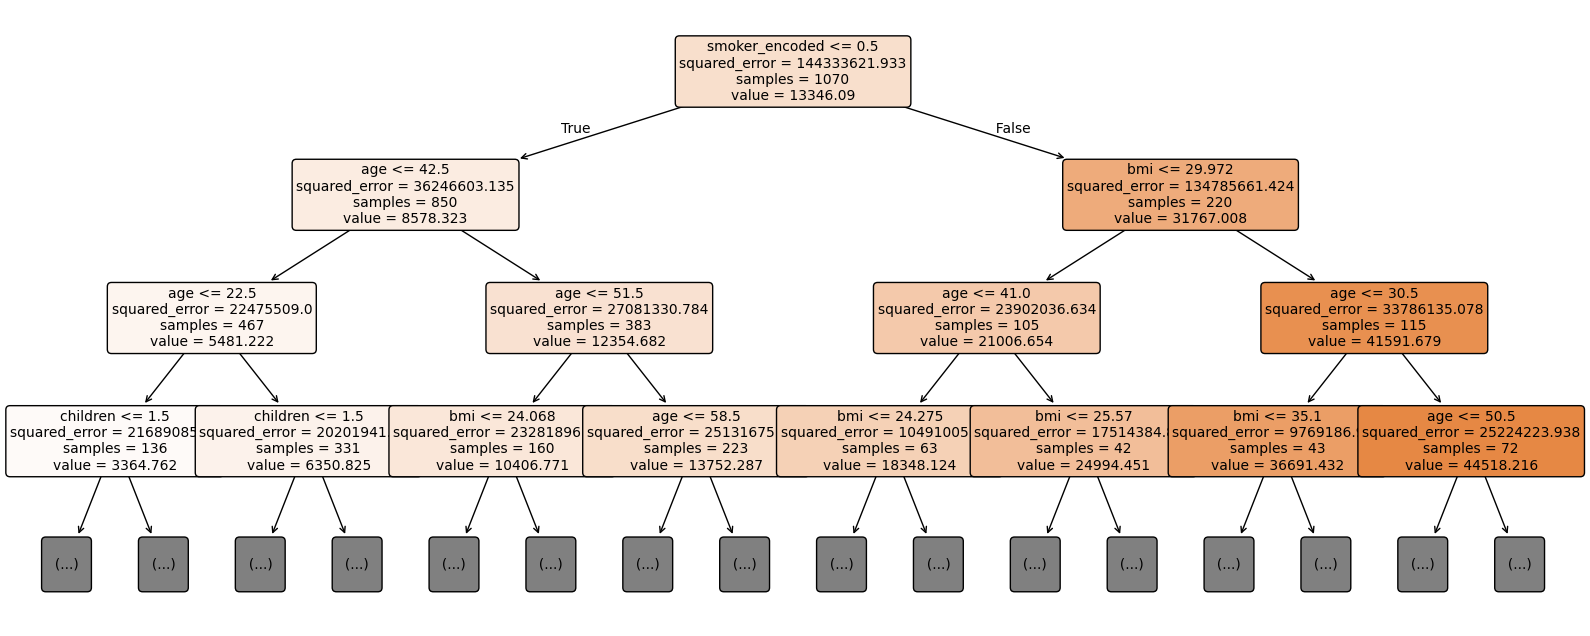

In [33]:
plt.figure(figsize=(20,8))
plot_tree(
    cv.best_estimator_, 
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.show()

### Random Forest Parameters Tuning

In [34]:
pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

param_grid = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [4, 8, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 5],
        'regressor__max_features': ['sqrt', 'log2']
    },
    {
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__subsample': [0.8, 1.0],
        'regressor__colsample_bytree': [0.8, 1.0],
        'regressor__min_child_weight': [1, 3]

    }
]

cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

print('Best parameters:', cv.best_params_)
print('Best score: %.2f' % cv.best_score_)
print('R^2 score on train test: %.2f' % r2_score(y_train, y_train_pred))
print('R^2 score on test test: %.2f' % r2_score(y_test, y_test_pred))

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
Best parameters: {'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...), 'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__n_estimator

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

<Figure size 600x400 with 0 Axes>

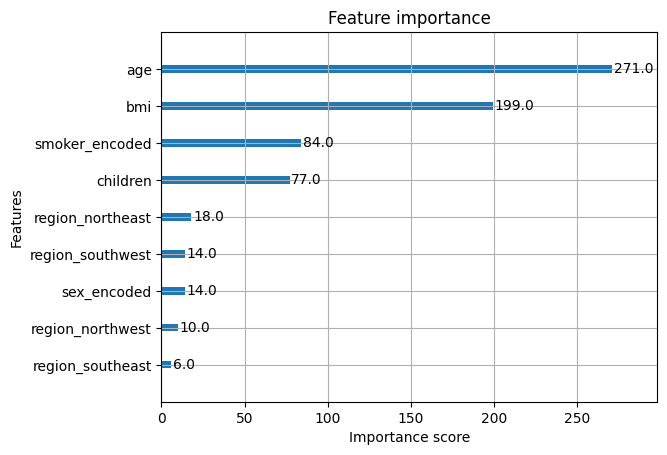

In [35]:
xgb_model = cv.best_estimator_ .named_steps['regressor']
plt.figure(figsize=(6,4))
plot_importance(xgb_model)

In [36]:
print('Metrics for the XGB Regressor (best model):')
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('R^2 Score: %.2f' % r2_score(y_test, y_test_pred))

Metrics for the XGB Regressor (best model):
Mean Absolute Error: 2338.59
Mean Squared Error: 18276255.26
Root Mean Squared Error: 4275.07
R^2 Score: 0.88


In [135]:
y.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

The model's average prediction error is 2338.59, which is about 17.6% of the mean medical charge (≈13270).
With an R² score of 0.88, this indicates the model explains most of the variance and performs well overall.